Model Performance:
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      3490
        True       0.08      0.03      0.04       331

    accuracy                           0.89      3821
   macro avg       0.50      0.50      0.49      3821
weighted avg       0.84      0.89      0.86      3821

ROC-AUC: 0.7260303499857166


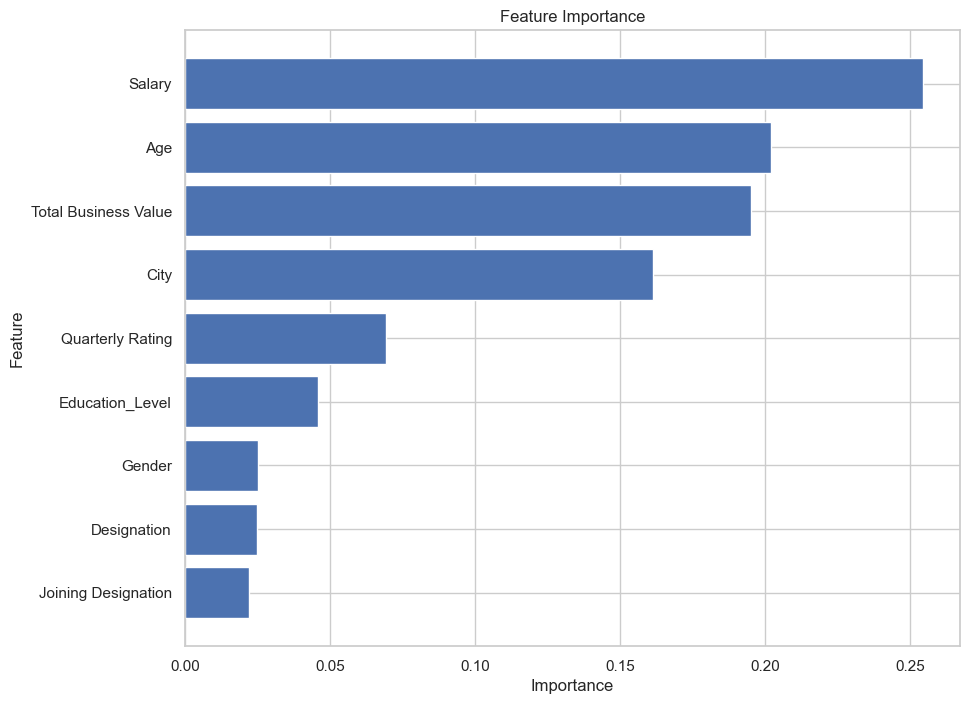

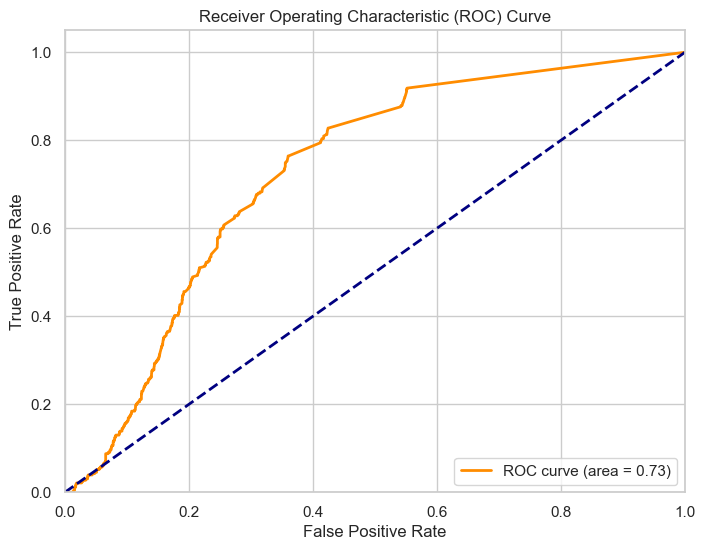

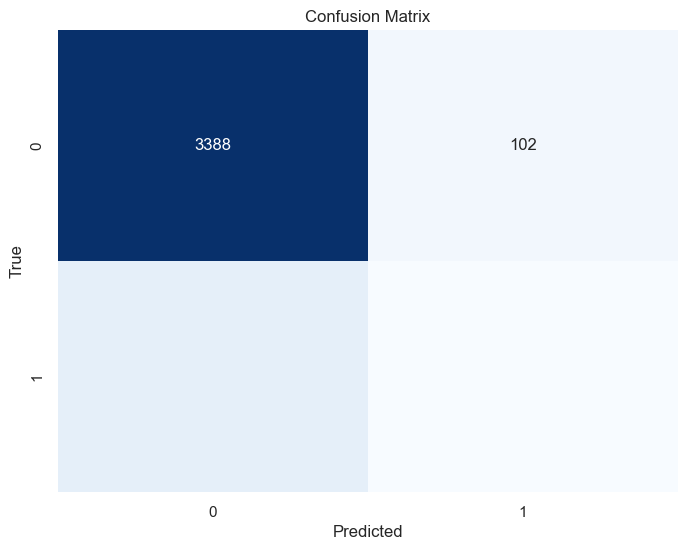

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Load the data
company = pd.read_csv('hr_data.csv')

# Handle missing values
company['LastWorkingDate'].fillna('2100-01-01', inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
company['Gender'] = label_encoder.fit_transform(company['Gender'])
company['City'] = label_encoder.fit_transform(company['City'])
company['Education_Level'] = label_encoder.fit_transform(company['Education_Level'])

# Convert date columns to datetime
company['MMM-YY'] = pd.to_datetime(company['MMM-YY'])
company['Dateofjoining'] = pd.to_datetime(company['Dateofjoining'])
company['LastWorkingDate'] = pd.to_datetime(company['LastWorkingDate'])

# Create a target column for attrition
company['Attrition'] = company['LastWorkingDate'] != pd.to_datetime('2100-01-01')

# Drop unnecessary columns
company.drop(columns=['MMM-YY', 'Emp_ID', 'Dateofjoining', 'LastWorkingDate'], inplace=True)

# Define features and target
X = company.drop(columns=['Attrition'])
y = company['Attrition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model (example: Random Forest)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print('Model Performance:')
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_prob)}')

# Predict attrition for all employees in the dataset
company_scaled = scaler.transform(X)
predictions = model.predict(company_scaled)
prediction_probs = model.predict_proba(company_scaled)[:, 1]

# Add predictions to the dataset
company['Attrition Prediction'] = ['Leave' if pred else 'Stay' for pred in predictions]
company['Probability of Leaving'] = prediction_probs * 100  # Convert to percentage


# Feature importances from the model
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()